© 2024 Luca Kunz. Commercial use is subject to the terms of the source repository's license. All other commercial rights are reserved.

# Find proximity pairs

We load the PROXIMITYRAW pkl files to find all drifters which have been assigned a closest TRAP.  
We Filter the dataframe for these proximity pairs and determine the proximity time aka **retention time** and proximity/retention age for every drifter-TRAP pair.

Then we export the final PROXIMITY dataframe and its PROXIMITY TIME RANKING TABLE as pkl files.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time
import datetime
import pickle

#%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs

from IPython.display import display, Audio
# import jupyter notebook files like regular python modules
import import_ipynb
from aa_define_classes import TRAPSdata

importing Jupyter notebook from aa_define_classes.ipynb


In [2]:
# measure the computation time for the entire script
start_script_timer = time.perf_counter()

# Preliminary

## Pickle object saving function

In [3]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

## Files and paths

In [4]:
# if script is running in jupyter lab
if sys.argv[0].endswith("ipykernel_launcher.py"):
    # set the velocity product
    vel_product_ID = 1
    epsilon_ID = 1
    rho_ID = 1
    drogue_ID = 1
    notebook_run = True
#    save_fig = True
    save_fig = False

    
# if script is running as python script
else:
    # read in product from bash
    vel_product_ID = int(sys.argv[1])
    # read in epsilon from bash
    epsilon_ID = int(sys.argv[2])
    # read in rho from bash
    rho_ID = int(sys.argv[3])
    # read in drogue state from bash
    drogue_ID = int(sys.argv[4])
    notebook_run = False
    save_fig = True


vel_product_short = ['ENSRYS_24HM', 'MULTIOBS_24HI', 'MULTIOBS_24HM', 'SEALEVEL_24HI'][vel_product_ID]

vel_product_long = ['CMEMS GLOBAL_REANALYSIS_PHY_001_031 ENSEMBLE MEAN (1/4°, 24HM)', 
                    'CMEMS MULTIOBS_GLO_PHY_REP_015_004 (1/4°, 24HI)', 
                    'CMEMS MULTIOBS_GLO_PHY_REP_015_004 (1/4°, 24HM)', 
                    'CMEMS SEALEVEL_GLO_PHY_L4_MY_008_047 (1/4°, 24HI)'][vel_product_ID]


years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', 
         '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

epsilon_value = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0][epsilon_ID]
epsilon_string = ['_e010', '_e025', '_e050', '_e075', '_e100', '_e125', '_e150', '_e175', '_e200'][epsilon_ID]

rho_kmvalue = [50, 75, 100, 150, 200, 250, 300][rho_ID] # in kilometres
rho_kmstring = ['_r050', '_r075', '_r100', '_r150', '_r200', '_r250', '_r300'][rho_ID] # in kilometres

gdp_product_ID = 2 # set this a priori
gdp_product_short = ['GDP_1HI', 'GDP_6HI', 'GDP_24HI'][gdp_product_ID]

drogue_state = ['_ALL', '_DROGUED', '_UNDROGUED'][drogue_ID]

In [5]:
# define the path to the pkl files
pkl_importpath = 'export_pkl/' + vel_product_short + '/'
pkl_exportpath = 'export_pkl/' + vel_product_short + '/'

# Import DataFrames

Load the PROXIMITYRAW dataframe for the given parameter settings.

In [6]:
# define the pkl files to load
pkl_importname = vel_product_short + epsilon_string + '_' + gdp_product_short
pkl_importname += drogue_state + '_TRAPS_DRIFTERS_PROXIMITYRAW_0019' + rho_kmstring + '.pkl'

# load the pickle object
with open(pkl_importpath + pkl_importname, 'rb') as inp:
    # cdf for current DataFrame, this will be overwritten every loop to save memory
    pd_PROXIMITY_RAW_df = pickle.load(inp).pd_TRAPS_df.copy()
    
    
# reset the index after loading
pd_PROXIMITY_RAW_df.reset_index(drop=True, inplace=True)

In [7]:
# print check
pd_PROXIMITY_RAW_df

,drifter_ID,time,drifter_lat,drifter_lon,drifter_U,drifter_V,drogued,TRAP_ID,distance_to_core,core_lon,...,core_attraction,distance_to_curve,closest_curvepoint_index,on_curve_25km,on_curve_50km,curve_lons,curve_lats,curve_attractions,lifetime,age
0,9936,2000-08-26,22.555,-155.354,-0.23282,0.25778,True,200008250000 003,60.231203,-155.817593,...,-0.221690,44.753500,0,False,True,"[-155.783577828023, -155.79707749613155, -155....","[22.625, 22.704810720714395, 22.78743570595080...","[-0.11997592682346567, -0.20103127384485994, -...",3,2
1,9936,2000-08-27,22.751,-155.505,-0.14815,0.24477,True,200008250000 003,45.624820,-155.920540,...,-0.241345,39.632725,1,False,True,"[-155.869339859782, -155.88833590230612, -155....","[22.625, 22.704113637047527, 22.78613715077547...","[-0.14627739393827804, -0.22086750171026764, -...",3,3
2,9936,2000-08-28,22.937,-155.619,-0.12629,0.22759,True,200008280000 005,63.503220,-155.038057,...,-0.322333,36.292468,10,False,True,"[-154.639507018582, -154.72214736697984, -154....","[23.1393782423944, 23.128798923691978, 23.1243...","[-0.10548432745900171, -0.15488850158324594, -...",1,1
3,9936,2000-08-29,23.084,-155.726,-0.11437,0.14587,True,200008160000 382,63.939969,-156.332764,...,-0.261863,46.455799,2,False,True,"[-156.104342192473, -156.1308178115604, -156.1...","[22.8126668383106, 22.891679659651107, 22.9686...","[-0.19404250569177095, -0.20864067275468554, -...",20,14
4,9936,2000-08-30,23.217,-155.862,-0.18390,0.16488,True,200008160000 382,52.500023,-156.373184,...,-0.266826,48.488312,4,False,True,"[-156.165390171374, -156.19838188553678, -156....","[22.7418923909432, 22.818406457314357, 22.8961...","[-0.17131150200438583, -0.20157973446601396, -...",20,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67880,300234066815360,2019-12-16,23.355,-148.910,0.06173,-0.21849,True,201912110000 022,41.771054,-148.603006,...,-0.374425,21.870150,1,True,True,"[-148.793472371587, -148.73719043412626, -148....","[23.1774017473982, 23.238620001927522, 23.3100...","[-0.15284800136797788, -0.17200012881030827, -...",15,6
67881,300234066815360,2019-12-17,23.188,-148.857,0.01730,-0.28545,True,201912110000 022,53.748656,-148.684404,...,-0.382894,2.753349,0,True,True,"[-148.861020460703, -148.80629222130955, -148....","[23.2125010489682, 23.27506165134894, 23.34828...","[-0.16212188821338594, -0.18326276282865117, -...",15,7
67882,300234066815360,2019-12-18,22.996,-148.873,0.00610,-0.38192,True,201912110000 022,69.536067,-148.632615,...,-0.405756,18.236315,0,True,True,"[-148.80407500915, -148.75006877303656, -148.7...","[23.1473678382077, 23.210577238937866, 23.2836...","[-0.17936583254398378, -0.19058664690798302, -...",15,8
67883,300234066815360,2019-12-19,22.719,-148.885,0.08513,-0.35683,True,,999.000000,999.000000,...,999.000000,999.000000,999,False,False,[],[],[],999,999


# Find drifter-TRAP pairs

We want to analyse the interaction of all drifter-TRAP pairs in the dataset.  
For this, we have to remove all drifter positions/rows which haven't been assigned some TRAP ID in the proximity algorithm.

In [8]:
# determine all drifters which have a close TRAP
pair_filter = (pd_PROXIMITY_RAW_df.TRAP_ID != '')

pd_PROXIMITY_df = pd_PROXIMITY_RAW_df[pair_filter].copy()
pd_NOPAIRS_df = pd_PROXIMITY_RAW_df[~pair_filter].copy()

# reset the index after cropping
pd_PROXIMITY_df.reset_index(drop=True, inplace=True)
pd_NOPAIRS_df.reset_index(drop=True, inplace=True)

In [9]:
# print check
pd_NOPAIRS_df
pd_PROXIMITY_df

,drifter_ID,time,drifter_lat,drifter_lon,drifter_U,drifter_V,drogued,TRAP_ID,distance_to_core,core_lon,...,core_attraction,distance_to_curve,closest_curvepoint_index,on_curve_25km,on_curve_50km,curve_lons,curve_lats,curve_attractions,lifetime,age
0,9936,2000-08-26,22.555,-155.354,-0.23282,0.25778,True,200008250000 003,60.231203,-155.817593,...,-0.221690,44.753500,0,False,True,"[-155.783577828023, -155.79707749613155, -155....","[22.625, 22.704810720714395, 22.78743570595080...","[-0.11997592682346567, -0.20103127384485994, -...",3,2
1,9936,2000-08-27,22.751,-155.505,-0.14815,0.24477,True,200008250000 003,45.624820,-155.920540,...,-0.241345,39.632725,1,False,True,"[-155.869339859782, -155.88833590230612, -155....","[22.625, 22.704113637047527, 22.78613715077547...","[-0.14627739393827804, -0.22086750171026764, -...",3,3
2,9936,2000-08-28,22.937,-155.619,-0.12629,0.22759,True,200008280000 005,63.503220,-155.038057,...,-0.322333,36.292468,10,False,True,"[-154.639507018582, -154.72214736697984, -154....","[23.1393782423944, 23.128798923691978, 23.1243...","[-0.10548432745900171, -0.15488850158324594, -...",1,1
3,9936,2000-08-29,23.084,-155.726,-0.11437,0.14587,True,200008160000 382,63.939969,-156.332764,...,-0.261863,46.455799,2,False,True,"[-156.104342192473, -156.1308178115604, -156.1...","[22.8126668383106, 22.891679659651107, 22.9686...","[-0.19404250569177095, -0.20864067275468554, -...",20,14
4,9936,2000-08-30,23.217,-155.862,-0.18390,0.16488,True,200008160000 382,52.500023,-156.373184,...,-0.266826,48.488312,4,False,True,"[-156.165390171374, -156.19838188553678, -156....","[22.7418923909432, 22.818406457314357, 22.8961...","[-0.17131150200438583, -0.20157973446601396, -...",20,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57558,300234066815360,2019-12-14,23.648,-148.937,-0.08284,-0.21683,True,201912110000 022,39.160872,-148.552352,...,-0.324708,38.062241,5,False,True,"[-148.739831909059, -148.68905134949495, -148....","[23.2094796686821, 23.27537504509859, 23.34926...","[-0.10927332306434152, -0.14863442931297136, -...",15,4
57559,300234066815360,2019-12-15,23.512,-148.918,-0.04516,-0.22107,True,201912110000 022,32.657723,-148.632829,...,-0.357320,24.310376,3,True,True,"[-148.813843705245, -148.76186193891706, -148....","[23.2130175079354, 23.277930345010667, 23.3519...","[-0.12026805743396467, -0.15379086594733143, -...",15,5
57560,300234066815360,2019-12-16,23.355,-148.910,0.06173,-0.21849,True,201912110000 022,41.771054,-148.603006,...,-0.374425,21.870150,1,True,True,"[-148.793472371587, -148.73719043412626, -148....","[23.1774017473982, 23.238620001927522, 23.3100...","[-0.15284800136797788, -0.17200012881030827, -...",15,6
57561,300234066815360,2019-12-17,23.188,-148.857,0.01730,-0.28545,True,201912110000 022,53.748656,-148.684404,...,-0.382894,2.753349,0,True,True,"[-148.861020460703, -148.80629222130955, -148....","[23.2125010489682, 23.27506165134894, 23.34828...","[-0.16212188821338594, -0.18326276282865117, -...",15,7


# Determine pair IDs

Now we want to create a new ID which helps identify every individual drifter-TRAP pair.  
For this, simply zipping both ID columns to create this new pair ID would be a coarse approach.  
One drifter might interact with a TRAP, then leave its surrounding and come back later to interact again with this same TRAP (if it has persisted in time of course). If we define pair IDs by simply zipping up drifter and TRAP IDs, these two visits would get the same pair ID, no matter how much time has passed in between.  
This would heavily skew the results to overestimated proximity times when counting the number of a specific pair ID's occurrences.

To sharpen this, we have to ensure that pair IDs only label drifter-TRAP encounters along consecutive timesteps.  
With this, the above example would generate two seperate pair IDs which would be valid for further analysis.  
The downside of considering only timestep-consecutive coexistences for a particular pair ID is that if drifter data is missing just for one timestep in between, it will split up the interaction into two different processes. For this one could implement a tolerance. However, atm we only focus on consecutive drifter-TRAP coexistences.

To get this, we have to iterate timewise through the drifter dataframe with A and B snapshots. Transfer the approach from the TRAPS tracking algorithm and call it proxpair algorithm.

## Introduce ID columns to dataframe

Define an auxilliary pair ID to roughly recognize pairs without considering the consecutiveness of timesteps/possible time gaps.  
Further insert the column for the more detailed pair ID (which is something like a subset of the auxilliary pair ID).

In [10]:
pd_PROXIMITY_df['aux_ID'] = list(zip(pd_PROXIMITY_df.drifter_ID, pd_PROXIMITY_df.TRAP_ID))
pd_PROXIMITY_df['pair_ID'] = ''

## Get timestamps and snapshots

Get the timestamps of all drifter positions.  
Since one timestamp may occur multiple times for different drifter positions, filter those duplicates to get the snapshots for the algorithm loop.

In [11]:
# get the timestamps from the drifter dataframe
timestamps = pd.to_datetime(pd_PROXIMITY_df.time.to_numpy(copy=True))

# and get the unique set of timestamps for the tracking loop
snapshots = pd.to_datetime(np.unique(timestamps)) # we need this sorted

In [12]:
# print check
timestamps
snapshots

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=7248, freq=None)

## Columns to arrays

The algorithm will work on individual drifter objects and subdataframes of the source dataframe but also on full columns of the source dataframe. In case of a 20-years source dataframe, these full columns may contain thousands of rows. To speed up the algorithm, these columns are converted to numpy arrays which are preferred since computing on arrays is much faster than computing on dataframe columns of large datasets.

In the end, the algorithm will work on drifter objects, subdataframes and these arrays, but will only update the full source dataframe instead of computing upon it.

In [13]:
drifter_IDs = pd_PROXIMITY_df.drifter_ID.to_numpy(copy=True)
TRAP_IDs = pd_PROXIMITY_df.TRAP_ID.to_numpy(copy=True)
pair_IDs = pd_PROXIMITY_df.pair_ID.to_numpy(copy=True) # object dtype, up to here only contains empty strings

In [14]:
# print check
drifter_IDs
TRAP_IDs
pair_IDs

array(['', '', '', ..., '', '', ''], dtype=object)

## Proxpair algorithm

Assign pair IDs to consecutive drifter-TRAP pairs.

In [15]:
start_timer = time.perf_counter()

In [16]:
####################################
# Select snapshots A and B
####################################

# iterate through [:-1] since we don't run the algorithm on the last snapshot
number_of_snapshots = snapshots[:-1].size
for snapshot_index_A in range(number_of_snapshots):

    snapshot_index_B = snapshot_index_A + 1
        
    
    ######################################
    # Select snapshots A and B
    ######################################
    
    
    # filters for drifters occuring on the snapshot dates
    time_filter_A = (timestamps==snapshots[snapshot_index_A]) # automatically returns numpy array
    time_filter_B = (timestamps==snapshots[snapshot_index_B]) # automatically returns numpy array

    # dataframes of the A and B snapshots
    pd_PROXIMITY_A_df = pd_PROXIMITY_df[time_filter_A].copy()
    pd_PROXIMITY_B_df = pd_PROXIMITY_df[time_filter_B].copy()

    # reset the index otherwise it would have jumps and might throw errors later
    pd_PROXIMITY_A_df.reset_index(drop=True, inplace=True)
    pd_PROXIMITY_B_df.reset_index(drop=True, inplace=True)

    # get column arrays of the snapshot dataframes    
    drifter_IDs_A = pd_PROXIMITY_A_df.drifter_ID.to_numpy(copy=True)
    drifter_IDs_B = pd_PROXIMITY_B_df.drifter_ID.to_numpy(copy=True)

    TRAP_IDs_A = pd_PROXIMITY_A_df.TRAP_ID.to_numpy(copy=True)
    TRAP_IDs_B = pd_PROXIMITY_B_df.TRAP_ID.to_numpy(copy=True)

    aux_IDs_A = pd_PROXIMITY_A_df.aux_ID.to_numpy(copy=True) # object dtype
    aux_IDs_B = pd_PROXIMITY_B_df.aux_ID.to_numpy(copy=True) # object dtype

    pair_IDs_A = pd_PROXIMITY_A_df.pair_ID.to_numpy(copy=True) # object dtype
    pair_IDs_B = pd_PROXIMITY_B_df.pair_ID.to_numpy(copy=True) # object dtype
    
    # we know that for a given timestamp, one drifter ID only occurs once (but TRAP IDs may occur multiple times)
    # and it is only mapped to one TRAP ID which means the aux ID is unique as well, show this by assertion
    assert np.all(np.sort(drifter_IDs_A)==np.unique(drifter_IDs_A)), 'found duplicate drifter ID at current A snapshot'
    assert np.all(np.sort(drifter_IDs_B)==np.unique(drifter_IDs_B)), 'found duplicate drifter ID at current B snapshot'
    assert np.all(np.sort(aux_IDs_A)==np.unique(aux_IDs_A)), 'found duplicate aux ID at current A snapshot'
    assert np.all(np.sort(aux_IDs_B)==np.unique(aux_IDs_B)), 'found duplicate aux ID at current B snapshot'
    
    
    ################################################
    # Determine consecutive drifter-TRAP pairs
    ################################################

    # iterate through the unique aux IDs in the A dataframe
    # assign the pair ID to the pair ID array at the respective position if it was not set before
    # see if the same aux ID also occurs in the B dataframe and if so, transfer the 
    # current pair ID to the right position in the B dataframe's pair ID array
    # ix_A for row index A
    for ix_A in range(pair_IDs_A.size):

        # assert that the current drifter ID has no more than 15 digits 
        # otherwise one has to change the padding of the pair ID
        assert len(drifter_IDs_A[ix_A]) <= 15, 'padding of the pair ID will be insufficient'

        # if there is no pair ID yet, build and assign it to the A drifter
        # otherwise move on with the transfer to the B dataframe
        if pair_IDs_A[ix_A]=='':

            # this is a unique ID since the drifter ID is unique at this snapshot
            current_pair_ID_A = (snapshots[snapshot_index_A].strftime('%Y%m%d%H%M')
                                 + ' ' + drifter_IDs_A[ix_A].zfill(15)
                                 + ' ' + TRAP_IDs_A[ix_A])

            # write to the pair ID subarray
            pair_IDs_A[ix_A] = current_pair_ID_A
            
        else:
            # this is how the pair ID is inherited
            current_pair_ID_A = pair_IDs_A[ix_A]

        
        current_aux_ID_A = aux_IDs_A[ix_A]
        # now see if the current aux ID in the A dataframe is also present in the B dataframe,
        # i.e. if we find the same drifter-TRAP pair in the next snapshot
        current_aux_ID_filter = [aux_ID_B==current_aux_ID_A for aux_ID_B in aux_IDs_B]
        
        # as the aux IDs are also unique at a given snapshot, the filter should have max. one True element
        assert sum(current_aux_ID_filter) <= 1, 'found current A aux ID more than once in B dataframe'
        
        # if the current A aux ID occurs in the B dataframe, transfer the respective pair ID
        if np.any(current_aux_ID_filter):

            # the B drifter can't have a pair ID yet by construction, assert this
            assert pair_IDs_B[current_aux_ID_filter]=='', 'B pair ID already set'
            
            # assign the current pair ID from the A drifter
            # this is how the pair ID is inherited
            pair_IDs_B[current_aux_ID_filter] = current_pair_ID_A

            
    # after iterating through the A dataframe, update the full pair IDs array using the latest subarrays
    pair_IDs[time_filter_A] = pair_IDs_A
    pair_IDs[time_filter_B] = pair_IDs_B
        
    # after one time loop finally update the source dataframe 
    # since the next A and B dataframes will be extracted from this
    pd_PROXIMITY_df['pair_ID'] = pair_IDs

    # show progress in terminal
    if not notebook_run:
        print('checked for consecutive drifter-TRAP pairs at snapshot ' 
              + str(snapshot_index_A+1).zfill(len(str(number_of_snapshots))) + '/' + str(number_of_snapshots))


# as explained above, the time iteration actually skips the last snapshot
# thus in the last time iteration there can be drifter-TRAP pairs in the B dataframe 
# that have not been assigned a pair ID yet, these are all drifter-TRAP pairs that newly emerged 
# in the last snapshot for which the pair ID needs to be constructed manually
lastnew_filter = (time_filter_B & (pair_IDs==''))

pair_IDs[lastnew_filter] = snapshots[snapshot_index_B].strftime('%Y%m%d%H%M') # the last snapshot timestamp
pair_IDs[lastnew_filter] = pair_IDs[lastnew_filter] + ' ' + [drifterID.zfill(15) for drifterID in drifter_IDs[lastnew_filter]]
pair_IDs[lastnew_filter] = pair_IDs[lastnew_filter] + ' ' + TRAP_IDs[lastnew_filter]


# assert that at the end, every pair has some pair ID
assert np.all(~(pair_IDs=='')), 'end of algorithm: found drifter-TRAP pair without pair ID'
# assert that at the end, every pair has exactly one pair ID
assert np.all([len(pair_ID)==45 for pair_ID in pair_IDs]), 'end of algorithm: found drifter-TRAP pair with corrupted pair ID'

# update source dataframe one last time
pd_PROXIMITY_df['pair_ID'] = pair_IDs

# remove the aux ID column again
del pd_PROXIMITY_df['aux_ID']

In [17]:
# get the unique set of pair IDs
pair_IDs_unique = np.unique(pair_IDs)

number_of_pairs = pair_IDs_unique.size

In [18]:
stop_timer = time.perf_counter()
print(f'proxpair algorithm runtime: {stop_timer - start_timer:0.4f} seconds')

proxpair algorithm runtime: 14.1228 seconds


In [19]:
#print check
#sum(lastnew_filter)
#pair_IDs
pd_PROXIMITY_df

,drifter_ID,time,drifter_lat,drifter_lon,drifter_U,drifter_V,drogued,TRAP_ID,distance_to_core,core_lon,...,distance_to_curve,closest_curvepoint_index,on_curve_25km,on_curve_50km,curve_lons,curve_lats,curve_attractions,lifetime,age,pair_ID
0,9936,2000-08-26,22.555,-155.354,-0.23282,0.25778,True,200008250000 003,60.231203,-155.817593,...,44.753500,0,False,True,"[-155.783577828023, -155.79707749613155, -155....","[22.625, 22.704810720714395, 22.78743570595080...","[-0.11997592682346567, -0.20103127384485994, -...",3,2,200008260000 000000000009936 200008250000 003
1,9936,2000-08-27,22.751,-155.505,-0.14815,0.24477,True,200008250000 003,45.624820,-155.920540,...,39.632725,1,False,True,"[-155.869339859782, -155.88833590230612, -155....","[22.625, 22.704113637047527, 22.78613715077547...","[-0.14627739393827804, -0.22086750171026764, -...",3,3,200008260000 000000000009936 200008250000 003
2,9936,2000-08-28,22.937,-155.619,-0.12629,0.22759,True,200008280000 005,63.503220,-155.038057,...,36.292468,10,False,True,"[-154.639507018582, -154.72214736697984, -154....","[23.1393782423944, 23.128798923691978, 23.1243...","[-0.10548432745900171, -0.15488850158324594, -...",1,1,200008280000 000000000009936 200008280000 005
3,9936,2000-08-29,23.084,-155.726,-0.11437,0.14587,True,200008160000 382,63.939969,-156.332764,...,46.455799,2,False,True,"[-156.104342192473, -156.1308178115604, -156.1...","[22.8126668383106, 22.891679659651107, 22.9686...","[-0.19404250569177095, -0.20864067275468554, -...",20,14,200008290000 000000000009936 200008160000 382
4,9936,2000-08-30,23.217,-155.862,-0.18390,0.16488,True,200008160000 382,52.500023,-156.373184,...,48.488312,4,False,True,"[-156.165390171374, -156.19838188553678, -156....","[22.7418923909432, 22.818406457314357, 22.8961...","[-0.17131150200438583, -0.20157973446601396, -...",20,15,200008290000 000000000009936 200008160000 382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57558,300234066815360,2019-12-14,23.648,-148.937,-0.08284,-0.21683,True,201912110000 022,39.160872,-148.552352,...,38.062241,5,False,True,"[-148.739831909059, -148.68905134949495, -148....","[23.2094796686821, 23.27537504509859, 23.34926...","[-0.10927332306434152, -0.14863442931297136, -...",15,4,201912130000 300234066815360 201912110000 022
57559,300234066815360,2019-12-15,23.512,-148.918,-0.04516,-0.22107,True,201912110000 022,32.657723,-148.632829,...,24.310376,3,True,True,"[-148.813843705245, -148.76186193891706, -148....","[23.2130175079354, 23.277930345010667, 23.3519...","[-0.12026805743396467, -0.15379086594733143, -...",15,5,201912130000 300234066815360 201912110000 022
57560,300234066815360,2019-12-16,23.355,-148.910,0.06173,-0.21849,True,201912110000 022,41.771054,-148.603006,...,21.870150,1,True,True,"[-148.793472371587, -148.73719043412626, -148....","[23.1774017473982, 23.238620001927522, 23.3100...","[-0.15284800136797788, -0.17200012881030827, -...",15,6,201912130000 300234066815360 201912110000 022
57561,300234066815360,2019-12-17,23.188,-148.857,0.01730,-0.28545,True,201912110000 022,53.748656,-148.684404,...,2.753349,0,True,True,"[-148.861020460703, -148.80629222130955, -148....","[23.2125010489682, 23.27506165134894, 23.34828...","[-0.16212188821338594, -0.18326276282865117, -...",15,7,201912130000 300234066815360 201912110000 022


# Determine proximity times and ages

For every pair, determine the amount of time the drifter has passed in the proximity of its closest TRAP by counting the occurrence of the respective pairID.  
Create a proximity time ranking table of pair IDs sorted by descending proximity time which shall be exported as **PTRT**.

Then add a proximity time column and a proximity age column to the overall dataframe.

## Build proximity time ranking table

Determine the proximity time of drifter-TRAP pairs by counting the occurrence of individual pair IDs.  
The proxpair algorithm was designed in a way that pair IDs can only last over consecutive timestamps without gaps.  
Thus the number of occurrences for a given pair ID describes for how many timesteps in a row it has persisted.  
The actual timestep depends on the chosen GDP product, i.e. 1 hour, 6 hours or 24 hours. 

In contrast to TRAP lifetime units, proximity times/ages will be displayed in hours to keep the script flexible with subdaily drifter data.  
Like for TRAPs, we also define that the first pair occurrence is at age 'timestep', e.g. 6h. This will lead to a proximity_time=counts * time_factor.  
We choose this because we can estimate the uncertainty of the later results to one timestep with the first encounter representing a proximity time of already timestep hours.

In [20]:
# to be on the safe side, reset the index of the dataframe
pd_PROXIMITY_df.reset_index(drop=True, inplace=True)

In [21]:
# dataframe containing all pair IDs and their counts
pd_PTRT_df = pd_PROXIMITY_df.value_counts(subset=['pair_ID']).reset_index(drop=False, inplace=False)
pd_PTRT_df.rename(columns={0: 'counts'}, inplace=True)

# get the unitless and unshifted counts
counts_PTRT = pd_PTRT_df.counts.to_numpy(copy=True)

# factor to transform the counts into units of hours
time_factor = [1, 6, 24][gdp_product_ID]

# determine the lifetime according to the definition above
pd_PTRT_df['proximity_time'] = (pd_PTRT_df.counts) * time_factor

# for each pair ID, we want a LIST of proximity ages a pair goes through until it reaches its final proximity time
# we want lists since later we will pop() proximity ages from these
# np.arange shifts counts by 1 such that we need to add 1 to the range array again
pd_PTRT_df['proximity_ages'] = [list((np.arange(counts)+1) * time_factor) for counts in counts_PTRT]

# turn PTRT into arrays for later assertions
pair_IDs_PTRT = pd_PTRT_df.pair_ID.to_numpy(copy=True)
proximity_times_PTRT = pd_PTRT_df.proximity_time.to_numpy(copy=True)

# assert that we have all pair IDs in the ranking table
assert np.all(pair_IDs_unique==np.sort(pair_IDs_PTRT)), 'unique pair IDs and PTRT pair IDs mismatch'

In [22]:
# print check

pd_PTRT_df

,pair_ID,counts,proximity_time,proximity_ages
0,201310310000 000000000101916 201310270000 344,46,1104,"[24, 48, 72, 96, 120, 144, 168, 192, 216, 240,..."
1,201905270000 300234066316870 201905150000 291,45,1080,"[24, 48, 72, 96, 120, 144, 168, 192, 216, 240,..."
2,201507280000 000000000132718 201507280000 374,44,1056,"[24, 48, 72, 96, 120, 144, 168, 192, 216, 240,..."
3,200010120000 000000009729746 200010120000 069,41,984,"[24, 48, 72, 96, 120, 144, 168, 192, 216, 240,..."
4,201102160000 000000000093582 201101310000 284,39,936,"[24, 48, 72, 96, 120, 144, 168, 192, 216, 240,..."
...,...,...,...,...
16804,200912120000 000000000079281 200912100000 524,1,24,[24]
16805,200912130000 000000000079271 200911250000 277,1,24,[24]
16806,200912130000 000000000079281 200911250000 268,1,24,[24]
16807,200912170000 000000000079281 200912170000 581,1,24,[24]


## Assign times and ages to dataframe

Assign all proximity times and ages to the respective pair IDs in the overall dataframe.  
Use the pandas mapping function and dictionaries for this since it is very very million times faster than working and assigning using boolean arrays!

For this we want to turn the proximity time ranking table into a dictionary which maps pair IDs to their time and age lists.

In [23]:
# prepare the ranking dataframe
pd_PTRT_MAPPING_df = pd_PTRT_df.drop(columns=['counts']).set_index('pair_ID').T.copy()

In [24]:
# convert the mapping dataframe into a dictionary which maps pair IDs to lifetimes and age lists
PTRT_MAPPING_DICTS = pd_PTRT_MAPPING_df.to_dict('records') # gives one dictionary per row, i.e. one for lifetime and one for ages

In [25]:
# get the individual dictionaries that map pair IDs to lifetimes or the age lists
TIMES_DICT = PTRT_MAPPING_DICTS[0]
AGES_DICT = PTRT_MAPPING_DICTS[1]

In [26]:
# print check
#pd_PTRT_df
#pd_PTRT_MAPPING_df
#PTRT_MAPPING_DICTS
#TIMES_DICT
#AGES_DICT

In [27]:
# map() substitutes each value in the series with another value that is derived from the dictionary and returns a series
# the returned series represents the new lifetime column
# this approach is a million times faster than assigning through arrays!
pd_PROXIMITY_df['proximity_time'] = pd_PROXIMITY_df.pair_ID.map(TIMES_DICT)

proximity_times = pd_PROXIMITY_df.proximity_time.to_numpy(copy=True)

# assert that every TRAP has a lifetime value greater than 0
assert np.all(proximity_times>0), 'found drifter-TRAP pair without proximity time'

Now assign one age value to each occurence of a given pair ID such that a pair ID's age increases with time.  
Check if pair ID occurrences in the dataframe are ordered chronologically in time. If this is not the case, activate the outcommented sorting above in the dataframe import section.  
Because when pair IDs (for themselves!) occur with time increasing order then we can go through the dataframe row by row and look up the respective age list for the current pair ID and pop() the first value.  
The succeeding occurence of the current pair ID will then get age+1 as this is the next first value of the age list.  
This is the fastest way of assigning ages I could find.

In [28]:
start_timer = time.perf_counter()

In [29]:
# assert that pair ID occurrences are in chronological order within the overall dataframe
for current_pairID in pair_IDs_unique:
    
    # get the timestamps of the current pair ID
    cp_timestamps = timestamps[pair_IDs==current_pairID]
    
    assert np.all(cp_timestamps==np.sort(cp_timestamps)), 'pair ID occurrences not in chronological order'

In [30]:
stop_timer = time.perf_counter()
print(f'asserted chronological pair IDs in: {stop_timer - start_timer:0.4f} seconds')

asserted chronological pair IDs in: 22.0411 seconds


In [31]:
start_timer = time.perf_counter()

In [32]:
# initiate the array for the proximity age column, reuse the previous pair IDs array
proximity_ages = np.zeros(pair_IDs.size).astype(int)

# when the assertion is passed, we can assign proximity ages
# assign through dictionaries and save hours instead of using boolean arrays!
for ix in range(pair_IDs.size):
    
    # as an age value is removed from its age list after assignement 
    # the next call of the same pair ID will get an increment of the recently assigned age
    proximity_ages[ix] = AGES_DICT[pair_IDs[ix]].pop(0)
    
# this shrinks the lists within the dictionary every iteration
# until finally, all lists have to be empty since all ages must have been assigned
assert not any(AGES_DICT.values()), 'found remaining proximity age values in ages dictionary'

# assert that the number of 'full-aged' pairs and the number of unique pair IDs are coherent
assert sum(proximity_times==proximity_ages)==pair_IDs_PTRT.size, 'found more/less full aged pairs than unique pair IDs'

# assign the new proximity age column to the overall dataframe
pd_PROXIMITY_df['proximity_age'] = proximity_ages

# remove the proximity age column again from the proximity times ranking table since it refers to the same age lists in the memory 
# and is also affected by pop(), bearing empty lists only
del pd_PTRT_df['proximity_ages']

In [33]:
stop_timer = time.perf_counter()
print(f'proximity age assignement finished in: {stop_timer - start_timer:0.4f} seconds')

proximity age assignement finished in: 0.0411 seconds


3.424534475578559

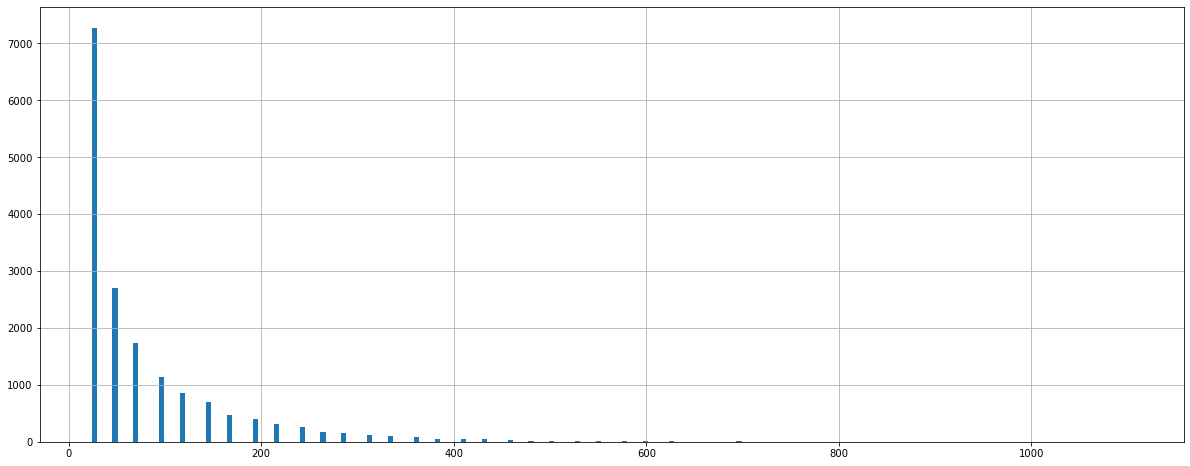

In [34]:
# print check
# pd_PROXIMITY_df
# pd_PTRT_df
pd_PTRT_df.proximity_time.hist(bins=200, figsize=(20.5,8))
# pd_PROXIMITY_df.proximity_time.hist(bins=200, figsize=(20.5,8))
# sum(pd_PTRT_df.proximity_time==24)
# sum(pd_PTRT_df.proximity_time==48)
pd_PTRT_df.proximity_time.mean()/24
# proximity_times
# proximity_ages

# Count TRAPS with only one curve point

The dataframe contains TRAPS with only one curvepoint ($\rightarrow$ curve core distance = 0) which are actually not useful to determine hyperbolic transport patterns since those TRAP curves indicate no direction. Here, we only make sure they represent below 0.1% of the data.

In [35]:
# TRUE flag all TRAPS which only consist of one or zero curvepoints, 
# i.e. the core, and thus won't show a curve core distance which is useless in the following
onezero_curvepoints_filter = np.array([ccurve_lons.size<=1 for ccurve_lons in pd_PROXIMITY_df.curve_lons])

print('dataset contains ' + str(sum(onezero_curvepoints_filter)) + ' curves with one/zero curvepoints')
print()

# make sure that this number is negligible
assert (sum(onezero_curvepoints_filter)/pd_PROXIMITY_df.index.size)<=0.001, 'too many TRAPs with one/zero curvepoints'

dataset contains 0 curves with one/zero curvepoints



## Reload column arrays

To make it more clear, reload the column arrays even though this might be redundant.

In [36]:
# columns to arrays
timestamps = pd.to_datetime(pd_PROXIMITY_df.time.to_numpy(copy=True))
pair_IDs = pd_PROXIMITY_df.pair_ID.to_numpy(copy=True) # object dtype, up to here only contains empty strings
proximity_times = pd_PROXIMITY_df.proximity_time.to_numpy(copy=True)

drifter_lons = pd_PROXIMITY_df.drifter_lon.to_numpy(copy=True)
drifter_lats = pd_PROXIMITY_df.drifter_lat.to_numpy(copy=True)

core_lons = pd_PROXIMITY_df.core_lon.to_numpy(copy=True)
core_lats = pd_PROXIMITY_df.core_lat.to_numpy(copy=True)
curve_lons = pd_PROXIMITY_df.curve_lons.to_numpy(copy=True)
curve_lats = pd_PROXIMITY_df.curve_lats.to_numpy(copy=True)

distances_to_core = pd_PROXIMITY_df.distance_to_core.to_numpy(copy=True)
distances_to_curve = pd_PROXIMITY_df.distance_to_curve.to_numpy(copy=True)

In [37]:
# get the unique set of pair IDs
pair_IDs_unique = np.unique(pair_IDs)

number_of_pairs = pair_IDs_unique.size
number_of_instances = pair_IDs.size

# Get drifter angles

For every instance of a drifter-TRAP pair, determine the vector pointing from core to drifter and get its angle to the zonal axis 0° pointing Eastwards and angle increasing counter-clockwise, this is the drifter angle.  

Provide this in degree-space and in kilometre-space.  
This could be used to determine if a drifter has been deviated by approx. 90° or for visualisations.

## Get drifter vector

In [38]:
# for every pair instance, find the components of the vector from TRAP core to drifter, in degrees
drifter_vector_lons = drifter_lons - core_lons
drifter_vector_lats = drifter_lats - core_lats

# and convert it into kilometres
drifter_vector_zonals = (1852*60*np.cos((drifter_lats+core_lats)/2 * np.pi/180) * drifter_vector_lons) / 1000

drifter_vector_meridionals = 1852*60*(drifter_vector_lats) / 1000

# distance to core should be the length of the drifter vector, compare in kilometres
assert np.all(np.around(distances_to_core, decimals=3)==np.around((drifter_vector_zonals**2 + drifter_vector_meridionals**2)**0.5, decimals=3)), 'found deprecated drifter vector'

## Get drifter angle

In [39]:
# get the angle between the drifter vector and the zonal axis, 
# with 0° pointing Eastward and angle increasing counter-clockwise

# in radians
drifter_angles_DEG = []
drifter_angles_KM = []

for ix in range(number_of_instances):
                
    ############################
    # IN DEGREES
    ############################
        
    # c for current
    cvector_lon = drifter_vector_lons[ix]
    cvector_lat = drifter_vector_lats[ix]

    
    if ((cvector_lon > 0) & (cvector_lat >= 0)): # [0°,90°)

        cdrifter_angle = abs(np.arctan(cvector_lat/cvector_lon))

    elif ((cvector_lon <= 0) & (cvector_lat > 0)): # [90°,180°)

        cdrifter_angle = np.pi/2 + abs(np.arctan(cvector_lon/cvector_lat))

    elif ((cvector_lon < 0) & (cvector_lat <= 0)): # [180°,270°)

        cdrifter_angle = np.pi + abs(np.arctan(cvector_lat/cvector_lon))

    elif ((cvector_lon >= 0) & (cvector_lat < 0)): # [270°,360°)

        cdrifter_angle = np.pi*3/2 + abs(np.arctan(cvector_lon/cvector_lat))
        
    else:

        raise ValueError('found drifter-TRAP pair with zero distance')

    drifter_angles_DEG.append(cdrifter_angle)
    

    ############################
    # IN KILOMETRES
    ############################
        
    # c for current
    cvector_zonal = drifter_vector_zonals[ix]
    cvector_meridional = drifter_vector_meridionals[ix]

    
    if ((cvector_zonal > 0) & (cvector_meridional >= 0)): # [0°,90°)

        cdrifter_angle = abs(np.arctan(cvector_meridional/cvector_zonal))

    elif ((cvector_zonal <= 0) & (cvector_meridional > 0)): # [90°,180°)

        cdrifter_angle = np.pi/2 + abs(np.arctan(cvector_zonal/cvector_meridional))

    elif ((cvector_zonal < 0) & (cvector_meridional <= 0)): # [180°,270°)

        cdrifter_angle = np.pi + abs(np.arctan(cvector_meridional/cvector_zonal))

    elif ((cvector_zonal >= 0) & (cvector_meridional < 0)): # [270°,360°)

        cdrifter_angle = np.pi*3/2 + abs(np.arctan(cvector_zonal/cvector_meridional))
        
    else:

        raise ValueError('found drifter-TRAP pair with zero distance')

    drifter_angles_KM.append(cdrifter_angle)

    
drifter_angles_DEG = np.array(drifter_angles_DEG)
drifter_angles_KM = np.array(drifter_angles_KM)

# assign to dataframe
pd_PROXIMITY_df['drifter_vector_lon'] = drifter_vector_lons
pd_PROXIMITY_df['drifter_vector_lat'] = drifter_vector_lats
pd_PROXIMITY_df['drifter_angle_DEG'] = drifter_angles_DEG

pd_PROXIMITY_df['drifter_vector_zonal'] = drifter_vector_zonals
pd_PROXIMITY_df['drifter_vector_meridional'] = drifter_vector_meridionals
pd_PROXIMITY_df['drifter_angle_KM'] = drifter_angles_KM

<AxesSubplot:>

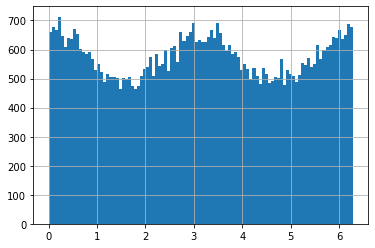

In [40]:
# print check
pd_PROXIMITY_df.drifter_angle_DEG.hist(bins=100)
# pd_PROXIMITY_df.sort_values(by='proximity_time', ascending=False)
# pd_PROXIMITY_df[pair_IDs=='201310270000 000000000101916 201308080000 066'].drifter_angle.plot()

<AxesSubplot:>

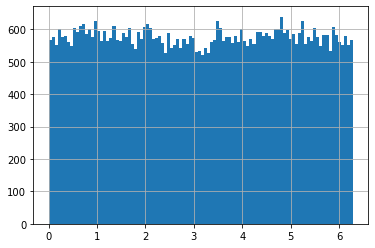

In [41]:
# print check
pd_PROXIMITY_df.drifter_angle_KM.hist(bins=100)
# pd_PROXIMITY_df.sort_values(by='proximity_time', ascending=False)
# pd_PROXIMITY_df[pair_IDs=='201310270000 000000000101916 201308080000 066'].drifter_angle.plot()

In [42]:
# print check
# pd_PROXIMITY_df[pair_IDs=='200811010000 000000000059863 200810290000 613'].distance_to_core.plot()
# pd_PROXIMITY_df[pair_IDs=='200811010000 000000000059863 200810290000 613'].distance_to_curve.plot(color='red')
pd_PROXIMITY_df

,drifter_ID,time,drifter_lat,drifter_lon,drifter_U,drifter_V,drogued,TRAP_ID,distance_to_core,core_lon,...,age,pair_ID,proximity_time,proximity_age,drifter_vector_lon,drifter_vector_lat,drifter_angle_DEG,drifter_vector_zonal,drifter_vector_meridional,drifter_angle_KM
0,9936,2000-08-26,22.555,-155.354,-0.23282,0.25778,True,200008250000 003,60.231203,-155.817593,...,2,200008260000 000000000009936 200008250000 003,48,24,0.463593,-0.333091,5.660152,47.516605,-37.013106,5.621412
1,9936,2000-08-27,22.751,-155.505,-0.14815,0.24477,True,200008250000 003,45.624820,-155.920540,...,3,200008260000 000000000009936 200008250000 003,48,48,0.415540,-0.147969,5.941097,42.559063,-16.442333,5.914509
2,9936,2000-08-28,22.937,-155.619,-0.12629,0.22759,True,200008280000 005,63.503220,-155.038057,...,1,200008280000 000000000009936 200008280000 005,24,24,-0.580943,-0.201953,3.476154,-59.405903,-22.440980,3.502778
3,9936,2000-08-29,23.084,-155.726,-0.11437,0.14587,True,200008160000 382,63.939969,-156.332764,...,14,200008290000 000000000009936 200008160000 382,144,24,0.606764,-0.140932,6.054965,61.992535,-15.660309,6.035746
4,9936,2000-08-30,23.217,-155.862,-0.18390,0.16488,True,200008160000 382,52.500023,-156.373184,...,15,200008290000 000000000009936 200008160000 382,144,48,0.511184,0.049388,0.096315,52.212402,5.487939,0.104723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57558,300234066815360,2019-12-14,23.648,-148.937,-0.08284,-0.21683,True,201912110000 022,39.160872,-148.552352,...,4,201912130000 300234066815360 201912110000 022,144,48,-0.384648,0.006660,3.124279,-39.153878,0.740097,3.122693
57559,300234066815360,2019-12-15,23.512,-148.918,-0.04516,-0.22107,True,201912110000 022,32.657723,-148.632829,...,5,201912130000 300234066815360 201912110000 022,144,72,-0.285171,-0.134407,3.582036,-29.042440,-14.935311,3.616582
57560,300234066815360,2019-12-16,23.355,-148.910,0.06173,-0.21849,True,201912110000 022,41.771054,-148.603006,...,6,201912130000 300234066815360 201912110000 022,144,96,-0.306994,-0.249044,3.823147,-31.288691,-27.673792,3.865759
57561,300234066815360,2019-12-17,23.188,-148.857,0.01730,-0.28545,True,201912110000 022,53.748656,-148.684404,...,7,201912130000 300234066815360 201912110000 022,144,120,-0.172596,-0.457034,4.351302,-17.599340,-50.785640,4.378798


In [43]:
# print check
pd_PTRT_df

,pair_ID,counts,proximity_time
0,201310310000 000000000101916 201310270000 344,46,1104
1,201905270000 300234066316870 201905150000 291,45,1080
2,201507280000 000000000132718 201507280000 374,44,1056
3,200010120000 000000009729746 200010120000 069,41,984
4,201102160000 000000000093582 201101310000 284,39,936
...,...,...,...
16804,200912120000 000000000079281 200912100000 524,1,24
16805,200912130000 000000000079271 200911250000 277,1,24
16806,200912130000 000000000079281 200911250000 268,1,24
16807,200912170000 000000000079281 200912170000 581,1,24


# Export pickle files

In [44]:
# create the object, using the former TRAPS object
PROXIMITY_data = TRAPSdata(vel_product_short, vel_product_long, pd_PROXIMITY_df)
PTRT_data = TRAPSdata(vel_product_short, vel_product_long, pd_PTRT_df)

In [45]:
# save the object as .pkl file
start_timer = time.perf_counter()

pkl_PROXIMITY_exportname = vel_product_short + epsilon_string + '_' + gdp_product_short
pkl_PROXIMITY_exportname += drogue_state + '_TRAPS_DRIFTERS_PROXIMITY_0019' + rho_kmstring + '.pkl'

pkl_PTRT_exportname = vel_product_short + epsilon_string + '_' + gdp_product_short
pkl_PTRT_exportname += drogue_state + '_TRAPS_DRIFTERS_PTRT_0019' + rho_kmstring + '.pkl'


# save the object as .pkl file                
save_object(PROXIMITY_data, pkl_exportpath + pkl_PROXIMITY_exportname)
save_object(PTRT_data, pkl_exportpath + pkl_PTRT_exportname)

stop_timer = time.perf_counter()

print('exported ' + pkl_PROXIMITY_exportname + f' in: {stop_timer - start_timer:0.1f} seconds')
print('exported ' + pkl_PTRT_exportname + f' in: {stop_timer - start_timer:0.1f} seconds')

exported MULTIOBS_24HI_e025_GDP_24HI_DROGUED_TRAPS_DRIFTERS_PROXIMITY_0019_r075.pkl in: 1.1 seconds
exported MULTIOBS_24HI_e025_GDP_24HI_DROGUED_TRAPS_DRIFTERS_PTRT_0019_r075.pkl in: 1.1 seconds


## End sound

In [46]:
# measure the computation time for the entire script
stop_script_timer = time.perf_counter()
print(f'overall computation time: {stop_script_timer - start_script_timer:0.3f} seconds')

overall computation time: 41.222 seconds


In [47]:
#https://gist.github.com/tamsanh/a658c1b29b8cba7d782a8b3aed685a24

framerate = 4410
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
# G-Dur
#audio_data = np.sin(2*np.pi*391*t) + np.sin(2*np.pi*493*t) + np.sin(2*np.pi*587*t)
# D-Dur
audio_data = np.sin(2*np.pi*293*t) + np.sin(2*np.pi*369*t) + np.sin(2*np.pi*440*t)
Audio(audio_data, rate=framerate, autoplay=True)